# **TECH CHALLENGER - FASE 4**



### Kleverson Valizerde Siqueira - 357339
### Ramon Eduardo Peters - 357522
### Rogério Viana - 357497
### Vinicius Almeida Barros - 357347

# **Instalação dos Pacotes**

In [204]:
!pip install numpy pandas requests inflection seaborn scipy matplotlib IPython scikit-learn statsmodels pmdarima tqdm statsforecast


**1.0 Importação**

In [205]:
import math
import numpy  as np
import pandas as pd
import random
import requests
import warnings
import inflection
import seaborn as sns
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.metrics       import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,r2_score
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree          import DecisionTreeRegressor
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima
from tqdm import tqdm

warnings.filterwarnings( 'ignore' )

**1.1 Funções de ajuda**

In [206]:
# função utilizada para calcular o erro dos modelos
# varia de acordo com o tipo de problema
# e a métrica escolhida para avaliar o desempenho.

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

**1.2 Carregando os dados**

In [207]:
# Carregando os dados do IBOVESPA
#df = pd.read_csv('/content/Dados Históricos - Ibovespa_2014_2024.csv')
# df = pd.read_excel('/content/preco_petroleo_ipea_base_2015_2025.xlsx')
# df = pd.read_excel('https://github.com/TorNDark/TechChallenge_Fase4/blob/main/preco_petroleo_ipea_base_2015_2025.xlsx')

In [208]:
import io
import requests
import pandas as pd

# Replace with the raw file URL from GitHub
url = 'https://raw.githubusercontent.com/TorNDark/TechChallenge_Fase4/main/preco_petroleo_ipea_base_2015_2025.xlsx'

# Fetch the file content
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses

# Read the Excel data using 'openpyxl' engine
df = pd.read_excel(io.BytesIO(response.content), engine='openpyxl')

**1.3 Detalhamento dos dados**

In [209]:
df1 = df.copy()

In [210]:
df1.head()

,Data,Preco
0,2025-02-10,76.23
1,2025-02-07,74.68
2,2025-02-06,74.54
3,2025-02-05,74.71
4,2025-02-04,76.58


**1.4 Dimensão dos dados**

In [211]:
# Verificando linhas e colunas do Data Frame
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 2971
Number of Cols: 2


**1.5. Detalhamento dos tipos de dados**

In [212]:
df1.dtypes

,0
Data,datetime64[ns]
Preco,float64


**1.6 Verificando os valores nulos**

In [213]:
# Checar os valores nulos
df1.isna().sum()

,0
Data,0
Preco,0


**1.7 Estatística descritiva**

In [214]:
# Dados estatísticos da base
df1.describe().T

,count,mean,min,25%,50%,75%,max,std
Data,2971,2019-08-14 05:13:06.401884672,2015-01-01 00:00:00,2017-01-12 12:00:00,2019-04-10 00:00:00,2022-03-05 12:00:00,2025-02-10 00:00:00,NaN
Preco,2971.0,64.580542,9.12,49.43,63.52,77.11,133.18,19.11233


**1.8 Atributos numéricos**

Neste gráfico de distribuição, demonstra Concentração de Preços: A maior parte dos preços está concentrada em uma faixa específica (60 a 100), indicando que esses valores são os mais comuns.
Picos: Os picos em torno de 70 e 80 sugerem que esses preços são particularmente frequentes, possivelmente devido a fatores de mercado ou características específicas dos produtos.

<Axes: xlabel='Preco'>

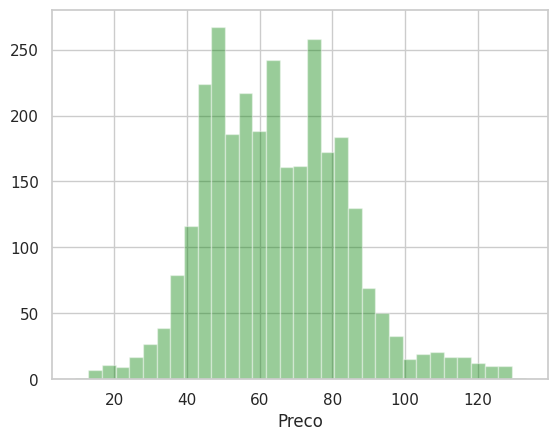

In [215]:
sns.distplot( df1['Preco'], kde=False, color='green' )

**2.0 Engenharia de recursos**

In [216]:
df2 = df1.copy()

Nesta etapa, adicionamos colunas extras para representar o dia, mês e ano separadamente, facilitando análises mais específicas, como a sazonalidade por mês e semana. Além disso, essa separação também contribui para melhorar o desempenho do modelo.

In [217]:
df2.set_index('Data', inplace=True)
# year
df2['year'] = df2.index.year
# month
df2['month'] = df2.index.month
# day
df2['day'] = df2.index.day
# week of year
df2['week_of_year'] = df2.index.isocalendar().week
# day of week
df2['day_of_week'] = df2.index.dayofweek

print(df2.dtypes)

Preco           float64
year              int32
month             int32
day               int32
week_of_year     UInt32
day_of_week       int32
dtype: object


In [218]:
#Verificando o nome das colunas existentes no Data Frame IPEA
print(df2.columns)

Index(['Preco', 'year', 'month', 'day', 'week_of_year', 'day_of_week'], dtype='object')


In [219]:
# Converter o índice do DataFrame em DatetimeIndex
df2.index = pd.to_datetime(df2.index)

# Classifique o índice para garantir que seja monotônico
df2 = df2.sort_index()

# Now, try slicing the DataFrame
#df2 = df2.loc['2020-01-01':'2024-06-30'] até junho 2024
df2 = df2.loc['2015-01-05':'2025-02-10']

In [220]:
df2.head()

,Preco,year,month,day,week_of_year,day_of_week
Data,,,,,,
2015-01-05,55.27,2015,1,5,2,0
2015-01-06,55.38,2015,1,6,2,1
2015-01-07,49.06,2015,1,7,2,2
2015-01-08,49.43,2015,1,8,2,3
2015-01-09,51.08,2015,1,9,2,4


**2.1 Criacao das Hipoteses**
1. O preço do petróleo varia de acordo com o dia da semana ?

2. O Mercado apresenta padrões de sazonalidade nos meses ?

3. Qual a tendência dos preços no último ano ?

4. O preço costuma fechar mais alto no último trimestre ?

**3.0 Análise de dados de exploração**

In [221]:
df3 = df2.copy()

In [222]:
df3['day_of_week'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

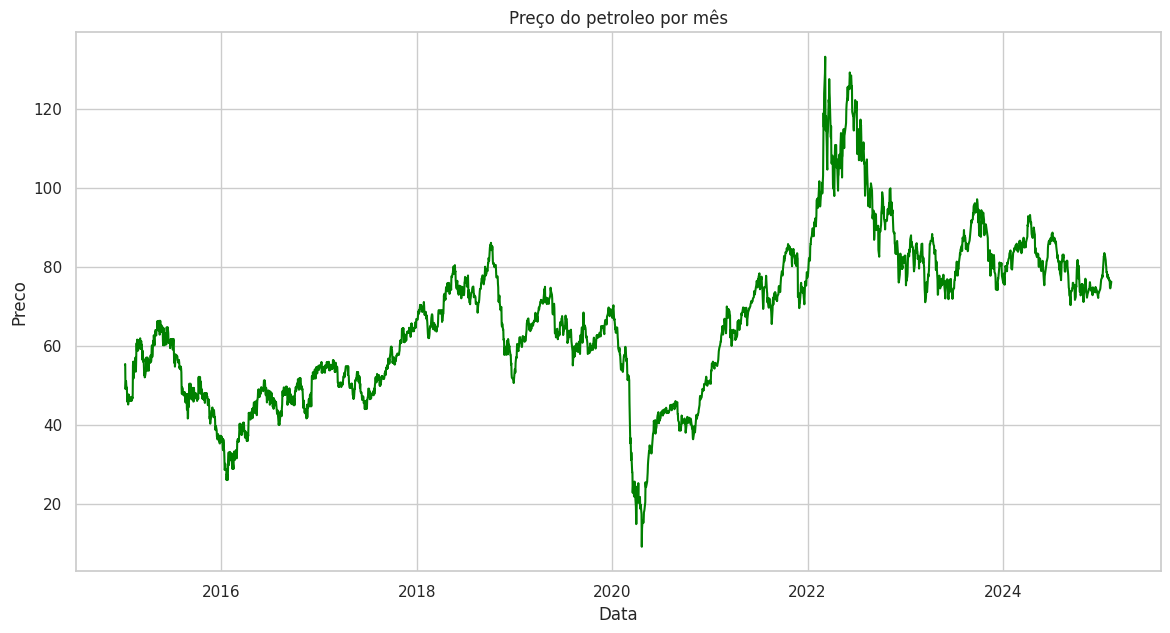

In [223]:
# Exibindo a distribuição do fechamento ao longo do período.
plt.figure(figsize=(14,7))
sns.lineplot(x=df3.index,y='Preco',data= df3,color='green')
plt.title('Preço do petroleo por mês')
plt.show()

Observou-se que a variável "ano" possui uma correlação forte com o alvo, apresentando uma correlação positiva ao longo do período analisado.

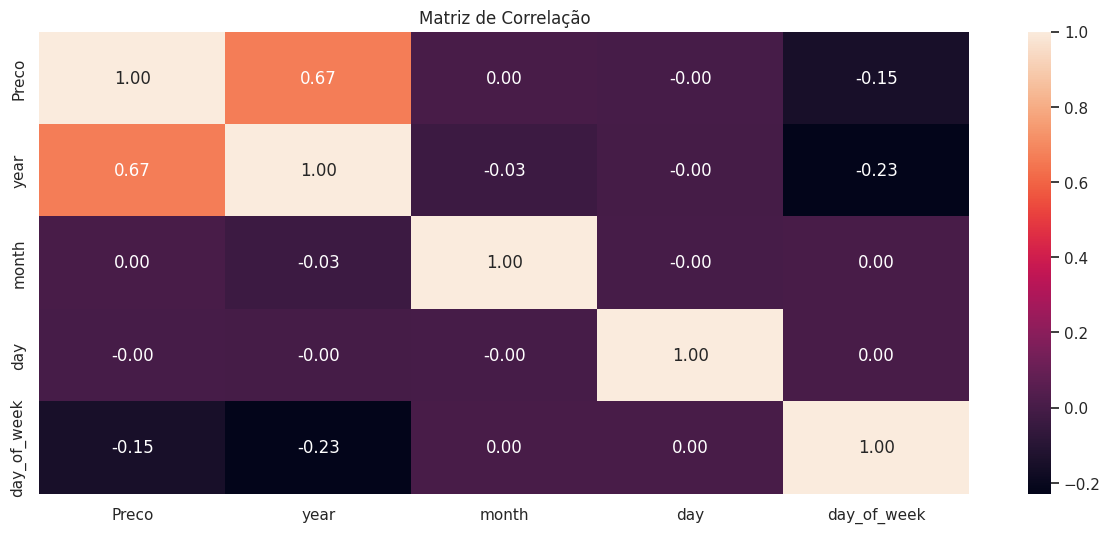

In [224]:
# Verificando a correlação entre as variáveis numéricas
plt.figure(figsize=(15,6))
num_attributes = df3.select_dtypes( include=['int32', 'float32', 'int64', 'float64'] )

correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True, fmt='.2f' )
plt.title('Matriz de Correlação')
plt.show()

**O preço do petróleo varia de acordo com o dia da semana?**

Resposta: Com base na matriz de correlação, podemos concluir que o preço do petróleo não varia de forma significativa de acordo com o dia da semana. Outros fatores, como eventos econômicos, geopolíticos e mudanças na oferta e demanda, têm um impacto muito maior nos preços do petróleo.

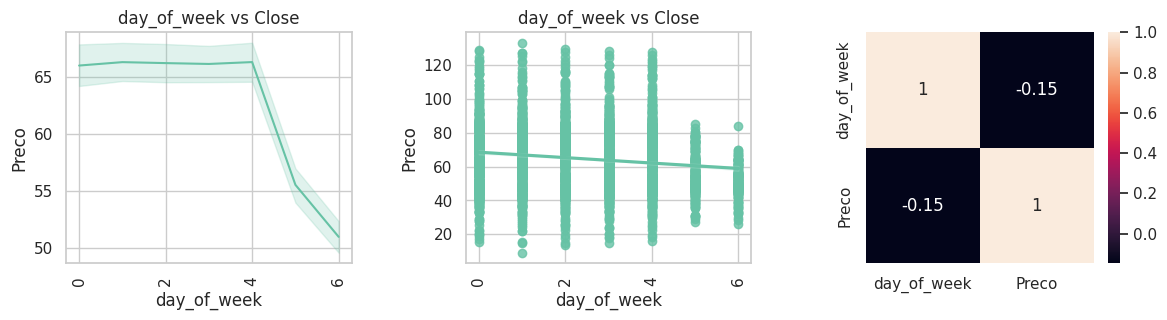

In [225]:
aux1 = df3[['day_of_week','Preco']]

fig, axes = plt.subplots(1, 3, figsize=(14, 3))
plt.subplots_adjust(wspace=0.4)
#fig.delaxes(axes[1, 0])

# Plot on the first subplot (axes[0, 0])
sns.lineplot(x='day_of_week', y='Preco', data=df3, ax=axes[0])
axes[0].set_title('day_of_week vs Close')
axes[0].tick_params(axis='x', rotation=90)

sns.regplot(x='day_of_week', y='Preco', data=df3, ax=axes[1])
axes[1].set_title('day_of_week vs Close')
axes[1].tick_params(axis='x', rotation=90)

sns.heatmap( aux1.corr( method='pearson' ), annot=True )


plt.show()

**O Mercado apresenta padrões de sazonalidade nos meses?**

Resposta: Com base nos gráficos, podemos concluir que o mercado apresenta padrões de sazonalidade nos meses. Os preços do petróleo variam de forma consistente em certos períodos do ano, sugerindo a presença de sazonalidade.

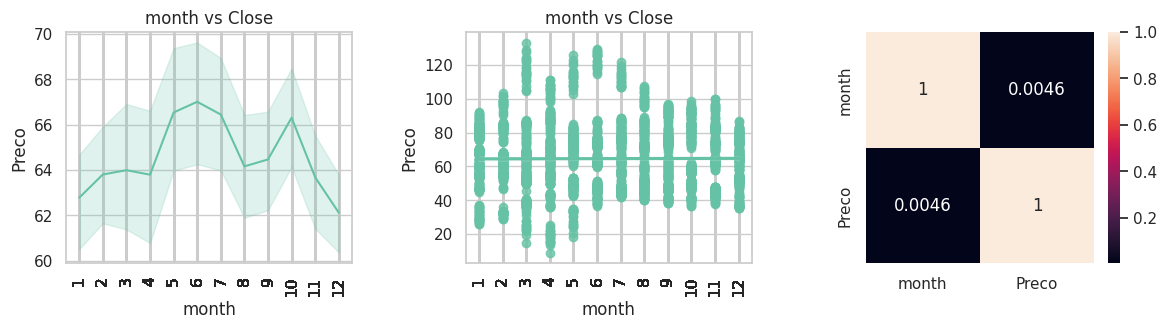

In [226]:
aux2 = df3[['month','Preco']]

fig, axes = plt.subplots(1, 3, figsize=(14, 3))
plt.subplots_adjust(wspace=0.4)
#fig.delaxes(axes[1, 0])

# Plot on the first subplot (axes[0, 0])
sns.lineplot(x='month', y='Preco', data=aux2, ax=axes[0])
axes[0].set_title('month vs Close')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xticks(aux2['month'])

sns.regplot(x='month', y='Preco', data=aux2, ax=axes[1])
axes[1].set_title('month vs Close')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(aux2['month'])

sns.heatmap( aux2.corr( method='pearson' ), annot=True )


plt.show()

**Qual a tendência do mercado no último ano?**

Resposta: Com base nos gráficos, podemos concluir que a tendência do mercado no último ano foi de alta nos preços do petróleo. O aumento gradual e consistente dos preços sugere uma recuperação ou um aumento na demanda por petróleo ao longo do período analisado.


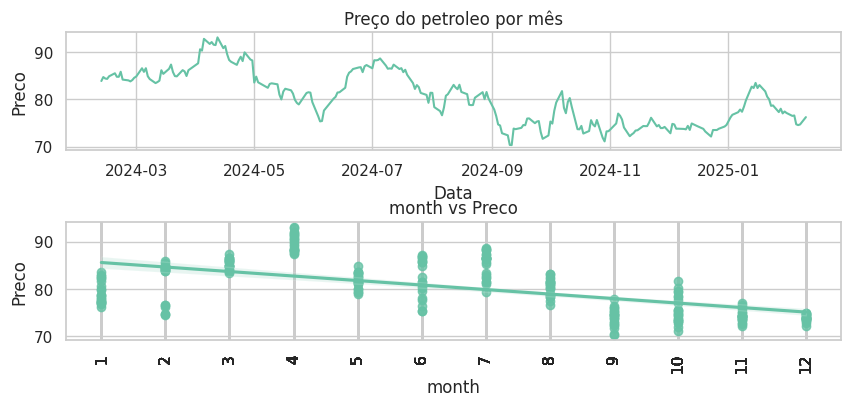

<Figure size 1500x400 with 0 Axes>

In [227]:
#aux4 = df3.loc['2023-06-01':'2024-06-30']
aux4 = df3.loc['2024-02-10':'2025-02-10']

fig, axes = plt.subplots(2, 1, figsize=(10, 4))
plt.subplots_adjust(hspace=0.6)

plt.figure(figsize=(15,4))
sns.lineplot(x=aux4.index,y='Preco',data= aux4, ax=axes[0])
axes[0].set_title('Preço do petroleo por mês')

sns.regplot(x='month', y='Preco', data=aux4, ax=axes[1])
axes[1].set_title('month vs Preco')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(aux4['month'])


plt.show()

**4.0 Preparação dos dados**

In [228]:
df4 = df3.copy()

In [229]:
df4.head()

,Preco,year,month,day,week_of_year,day_of_week
Data,,,,,,
2015-01-05,55.27,2015,1,5,2,0
2015-01-06,55.38,2015,1,6,2,1
2015-01-07,49.06,2015,1,7,2,2
2015-01-08,49.43,2015,1,8,2,3
2015-01-09,51.08,2015,1,9,2,4


**5.0 Reescalonamento**

In [230]:
df5 = df4.copy()

Nesta etapa, transformamos as colunas temporais, normalizando-as para um intervalo de 0 a 1. Essa transformação foi realizada com o objetivo de melhorar o desempenho dos modelos.

**5.1 Transformação de natureza**

In [231]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )



features = df5[['day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]

# Adicione essas características ao seu conjunto de dados original
df5 = pd.concat([df5, features], axis=1)

# Agora você pode usar df5 em seu modelo de machine learning

**6.0 Seleção de características**

In [232]:
df6 = df5.copy()
df6.columns

Index(['Preco', 'year', 'month', 'day', 'week_of_year', 'day_of_week',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos'],
      dtype='object')

In [233]:
# Converter o índice do DataFrame em DatetimeIndex
df6.index = pd.to_datetime(df6.index)

# Classifique o índice para garantir que seja monotônico
df6 = df6.sort_index()

# Now, try slicing the DataFrame
#df2 = df2.loc['2020-01-01':'2024-06-30'] até junho 2024
df6 = df6.loc['2024-01-01':'2025-02-10']

In [234]:
df6.head()

,Preco,year,month,day,week_of_year,day_of_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos
Data,,,,,,,,,,,,,,,,,,
2024-01-02,76.24,2024,1,2,1,1,0.781831,0.623490,0.5,0.866025,0.406737,0.913545,0.781831,0.623490,0.5,0.866025,0.406737,0.913545
2024-01-03,77.18,2024,1,3,1,2,0.974928,-0.222521,0.5,0.866025,0.587785,0.809017,0.974928,-0.222521,0.5,0.866025,0.587785,0.809017
2024-01-04,75.79,2024,1,4,1,3,0.433884,-0.900969,0.5,0.866025,0.743145,0.669131,0.433884,-0.900969,0.5,0.866025,0.743145,0.669131
2024-01-05,78.31,2024,1,5,1,4,-0.433884,-0.900969,0.5,0.866025,0.866025,0.500000,-0.433884,-0.900969,0.5,0.866025,0.866025,0.500000
2024-01-08,75.47,2024,1,8,2,0,0.000000,1.000000,0.5,0.866025,0.994522,-0.104528,0.000000,1.000000,0.5,0.866025,0.994522,-0.104528


**6.1 Separando os dados em treino e teste**

In [235]:
df6 = df6['Preco'].reset_index()
#df6.set_index('Data', inplace=True)

df6.rename(columns={'Preco': 'y','Data': 'ds'}, inplace=True)

In [236]:
# training dataset
X_train = df6[df6['ds'] < '2025-01-01']
y_train = X_train['y']

# test dataset
X_test = df6[df6['ds'] > '2025-01-01']
y_test = X_test['y']

h = X_test['ds'].nunique()
print( 'Training Min Date: {}'.format( X_train['ds'].min() ) )
print( 'Training Max Date: {}'.format( X_train['ds'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['ds'].min() ) )
print( 'Test Max Date: {}'.format( X_test['ds'].max() ) )

Training Min Date: 2024-01-02 00:00:00
Training Max Date: 2024-12-31 00:00:00

Test Min Date: 2025-01-02 00:00:00
Test Max Date: 2025-02-10 00:00:00


In [237]:
df6.head()

,ds,y
0,2024-01-02,76.24
1,2024-01-03,77.18
2,2024-01-04,75.79
3,2024-01-05,78.31
4,2024-01-08,75.47


**7.0 MACHINE LEARNING MODELLING**

**7.1. Arima Model**

Para o período que utilizamos , o resultado ADF nos mostrou que o p_value é 0.2% rejeitando a hipótese nula. Por esse motivo seguimos com ao treinamento e predição do modelo sem transformar a escala dos dados.

In [238]:
# teste ADF ( estacionaridade)
# Se o P Value <= 0.05 (5%) , então rejeitamos a hipótese Nula, com nível de confiança de 95%

# H0 - Hipótese Nula ( Série não é estacionária)
# H1 - Hipótese Alternativa ( Série é estacionária)
X = df6['y'].values
result = adfuller(X)

# Resultado : Hipótese Nula Rejeitada - Apesar do teste estatístico ser maior do que os valores críticos,
# o P-Value é de 3%, refeijando a hipótese Nula.

print('Teste ADF ')
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores Críticos :")

for key,value in result[4].items():
    print(f"\t {key}: {value}")

Teste ADF 
Teste Estatístico: -2.0905952736076983
P-Value: 0.2483130667209592
Valores Críticos :
	 1%: -3.453922368485787
	 5%: -2.871918329081633
	 10%: -2.5723001147959184


In [239]:
# Função para realizar o Teste de Dickey-Fuller e imprimir os resultados

def adf_test(timeseries):
  result = adfuller(timeseries, autolag='AIC')

  print('Resultado do Teste:')
  print('Estatistica do Teste:', result[0])
  print ('Valor p:', result[1])
  print('Valores Críticos')
  for key, value in result[4].items():
    print(f'\t{key}: {value}')

    if result[1] <= 0.05:
      print("\nResultado: A série é estacionaria.")
    else:
      print("\nResultado: A série não é estacionaria.")

In [240]:
adf_test(df6['y'].dropna())

Resultado do Teste:
Estatistica do Teste: -2.0905952736076983
Valor p: 0.2483130667209592
Valores Críticos
	1%: -3.453922368485787

Resultado: A série não é estacionaria.
	5%: -2.871918329081633

Resultado: A série não é estacionaria.
	10%: -2.5723001147959184

Resultado: A série não é estacionaria.


In [241]:
df1.head()

,Data,Preco
0,2025-02-10,76.23
1,2025-02-07,74.68
2,2025-02-06,74.54
3,2025-02-05,74.71
4,2025-02-04,76.58


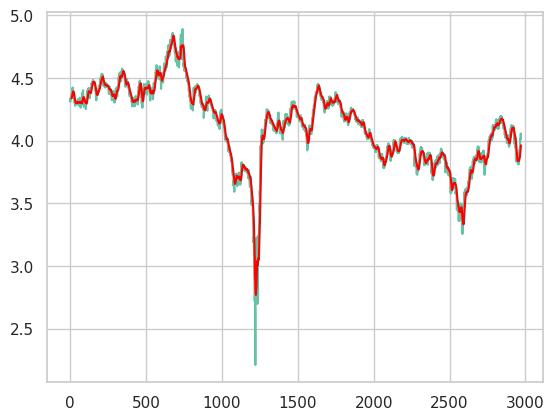

In [242]:
#Estimating trend
# Ensure 'Preco' column is of numeric type
df1['Preco'] = pd.to_numeric(df1['Preco'], errors='coerce')

# Apply log transformation only to the 'Preco' column
dados_log = np.log(df1['Preco']) #Transformação logarítma

# Now proceed with calculating the moving average and plotting
ma = dados_log.rolling(window=12).mean()
mstd = dados_log.rolling(window=12).std()

# Calculate dados_log_minus_ma here
dados_log_minus_ma = dados_log - ma

# Fix: Remove NaN values before applying the test
dados_log_minus_ma = dados_log_minus_ma.dropna()

plt.plot(dados_log)
plt.plot(ma, color='red')



In [243]:
def test_stationarity(timeseries):
    # Determinar estatísticas contínuas

    ma = timeseries.rolling(window=12).mean()
    mstd = timeseries.rolling(window=12).std()
    # Plot estatísticas contínuas
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(ma,color='red',label='Rolling Mean')
    std = plt.plot(mstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    # Applying adfuller directly to the timeseries data
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'% key]= value
    print(dfoutput)
    # Tomar uma decisão com base no valor p
    if dfoutput['p-value'] <= 0.05:
        print("\nResultado: A série é estacionária.")
    else:
        print("\nResultado: A série não é estacionária.")

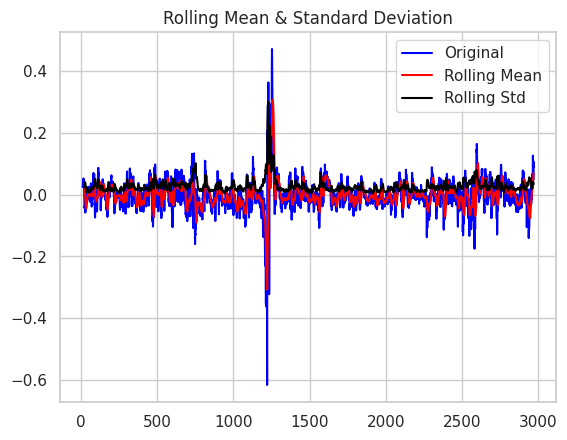

Results of Dickey Fuller Test:
Test Statistic                -9.045907e+00
p-value                        4.987739e-15
#Lags Used                     2.700000e+01
Number of Observations Used    2.932000e+03
Critical Value (1%)           -3.432582e+00
Critical Value (5%)           -2.862526e+00
Critical Value (10%)          -2.567295e+00
dtype: float64

Resultado: A série é estacionária.


In [244]:
test_stationarity(dados_log_minus_ma)

In [245]:
from pmdarima import auto_arima

# Série temporal: series
auto_model = auto_arima(X_train['y'], suppress_warnings=True)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  253
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -428.673
Date:                Thu, 20 Feb 2025   AIC                            859.345
Time:                        15:21:58   BIC                            862.875
Sample:                             0   HQIC                           860.765
                                - 253                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.7582      0.132     13.358      0.000       1.500       2.016
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                11.07
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.30
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

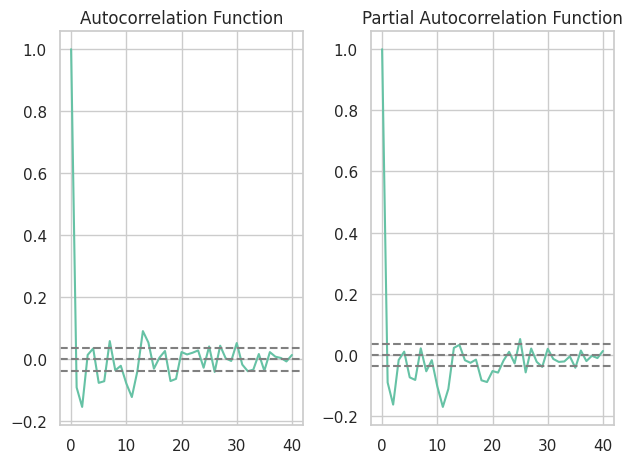

In [246]:
from statsmodels.tsa.stattools import acf, pacf # importing acf and pacf functions

# Calculate the first difference of the log-transformed data
dados_log_minus_DiffShifting = dados_log_minus_ma.diff().dropna()

lag_acf = acf(dados_log_minus_DiffShifting, nlags=40)
lag_pacf = pacf(dados_log_minus_DiffShifting, nlags=40, method='ols')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dados_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dados_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dados_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dados_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [247]:
# ARIMA MODEL

#p, d, q = 1, 0, 1
p, d, q = 2, 1, 24


arima_model = ARIMA(X_train['y'], order=(p, d, q))
arima_fit = arima_model.fit()

# FIT AND PREDICT
h = h
forecast = arima_fit.get_forecast(steps=h)
forecast_values = forecast.predicted_mean

# Convertendo em DF para Merge
df_arima = pd.DataFrame(forecast_values)
X_test_a = pd.DataFrame(X_test)

# Resetando os índices

df_arima = df_arima.reset_index(drop=True).reset_index()
X_test_a = X_test_a.reset_index(drop=True).reset_index()

In [248]:
df_arima['predicted_mean'] = df_arima['predicted_mean'].round(3)
result_a = X_test_a.merge(df_arima,on='index',how='left')
result_a.head(10)

,index,ds,y,predicted_mean
0,0,2025-01-02,76.14,74.476
1,1,2025-01-03,76.72,74.045
2,2,2025-01-06,77.27,74.183
3,3,2025-01-07,77.84,74.214
4,4,2025-01-08,77.37,74.254
5,5,2025-01-09,78.44,74.195
6,6,2025-01-10,79.76,73.788
7,7,2025-01-13,82.69,74.116
8,8,2025-01-14,82.39,74.190
9,9,2025-01-15,83.48,74.377


In [249]:
# performance
arima_result = ml_error( 'Arima Model', y_test, forecast_values )
arima_result

,Model Name,MAE,MAPE,RMSE
0,Arima Model,4.189185,0.052376,4.918991


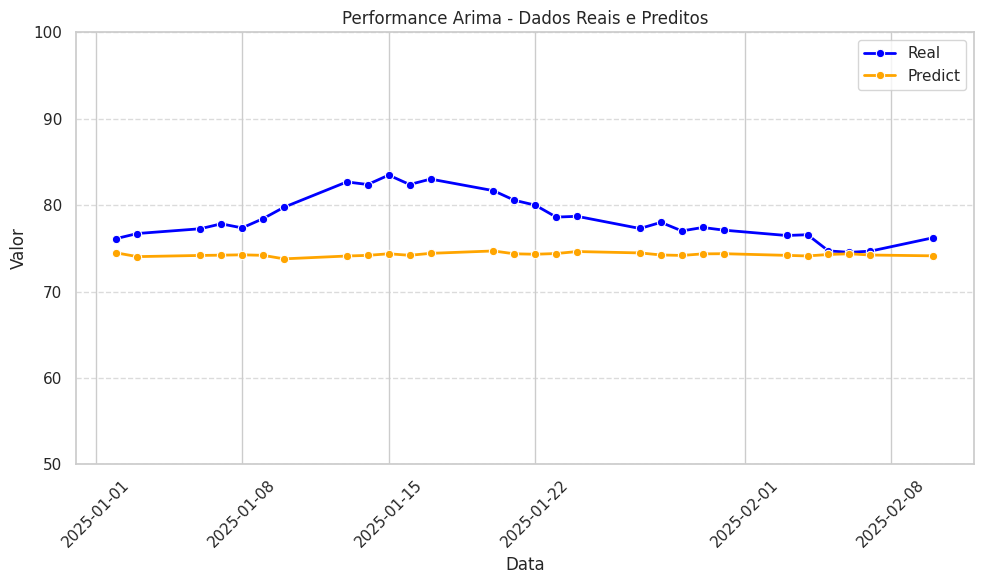

In [250]:
# Configuração do estilo do seaborn
sns.set(style='whitegrid', palette='Set2')

# Criar o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(x='ds', y='y', data=result_a, label='Real', marker='o', color='blue', linewidth=2)
sns.lineplot(x='ds', y='predicted_mean', data=result_a, label='Predict', marker='o', color='orange', linewidth=2)
plt.ylim(50,100)

# Adicionar rótulos e legendas
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Performance Arima - Dados Reais e Preditos')
plt.legend()

# Rotacionar as datas para melhorar a legibilidade
plt.xticks(rotation=45)

# Adicionar grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

**7.2 Modelo de regressão linear**

In [251]:
df5.head()

,Preco,year,month,day,week_of_year,day_of_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos
Data,,,,,,,,,,,,,,,,,,
2015-01-05,55.27,2015,1,5,2,0,0.000000,1.000000,0.5,0.866025,0.866025,0.500000,0.000000,1.000000,0.5,0.866025,0.866025,0.500000
2015-01-06,55.38,2015,1,6,2,1,0.781831,0.623490,0.5,0.866025,0.951057,0.309017,0.781831,0.623490,0.5,0.866025,0.951057,0.309017
2015-01-07,49.06,2015,1,7,2,2,0.974928,-0.222521,0.5,0.866025,0.994522,0.104528,0.974928,-0.222521,0.5,0.866025,0.994522,0.104528
2015-01-08,49.43,2015,1,8,2,3,0.433884,-0.900969,0.5,0.866025,0.994522,-0.104528,0.433884,-0.900969,0.5,0.866025,0.994522,-0.104528
2015-01-09,51.08,2015,1,9,2,4,-0.433884,-0.900969,0.5,0.866025,0.951057,-0.309017,-0.433884,-0.900969,0.5,0.866025,0.951057,-0.309017


In [252]:
# training dataset
X_train_lr = df5.loc[ '2024-01-01': '2024-08-10'].drop(columns='Preco')
y_train_lr = df5['Preco'].loc['2024-01-01': '2024-08-10']
#X_train_lr = df5.loc[ '2020-01-01': '2024-06-30'].drop(columns='Último')
#y_train_lr = df5['Último'].loc['2020-01-01': '2024-06-30']

# test dataset
X_test_lr = df5.loc[ '2024-08-11': '2025-02-10'].drop(columns='Preco')
#X_test_lr = df5.loc[ '2024-01-01':'2024-06-30'].drop(columns='Último')
y_test_lr = df5['Preco'].loc['2024-08-11': '2025-02-10']
#y_test_lr = df5['Último'].loc['2024-01-01':'2024-06-30']

print( 'Training Min Date: {}'.format( X_train_lr.index.min() ) )
print( 'Training Max Date: {}'.format( X_train_lr.index.max() ) )

print( '\nTest Min Date: {}'.format( X_test_lr.index.min() ) )
print( 'Test Max Date: {}'.format( X_test_lr.index.max() ) )

Training Min Date: 2024-01-02 00:00:00
Training Max Date: 2024-08-09 00:00:00

Test Min Date: 2024-08-12 00:00:00
Test Max Date: 2025-02-10 00:00:00


In [253]:
# 1° modelo de regressão linear
modelo = LinearRegression()

# Treine o modelo no conjunto de treinamento
modelo.fit(X_train_lr, y_train_lr)

# Faça previsões no conjunto de teste
y_pred = modelo.predict(X_test_lr)

# performance
#lr_result = ml_error( 'Linear Regression', y_test, y_pred )
lr_result = ml_error( 'Linear Regression', y_test_lr, y_pred ) # Fix: change to y_test_lr
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,14.061057,0.188926,17.084343


In [254]:
df_lr = pd.DataFrame(y_pred).reset_index()
result_lr = X_test_a.merge(df_lr,on='index',how='left')
result_lr.rename(columns={0: 'lr_predict'}, inplace=True)

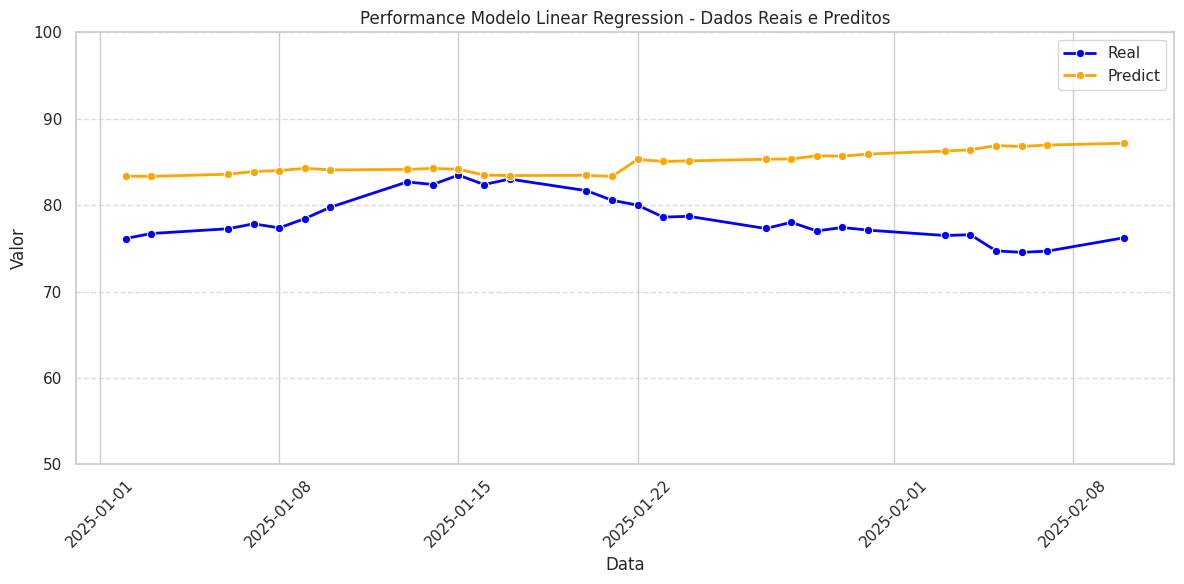

In [255]:
# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='y', data=result_lr, label='Real', marker='o', color='blue', linewidth=2)
sns.lineplot(x='ds', y='lr_predict', data=result_lr, label='Predict', marker='o', color='orange', linewidth=2)
plt.ylim(50,100)
# Adicionar intervalo de confiança se disponível (substitua 'ic_lower' e 'ic_upper' com seus nomes reais)
# sns.fill_between(x=result_a['ds'], y1=result_a['ic_lower'], y2=result_a['ic_upper'], color='gray', alpha=0.2, label='Confidence Interval')

# Adicionar rótulos e legendas
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Performance Modelo Linear Regression - Dados Reais e Preditos')
plt.legend()

# Rotacionar as datas para melhorar a legibilidade
plt.xticks(rotation=45)

# Adicionar grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

**7.3 Modelo de árvore de decisão**

In [256]:
# Criar o modelo de Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)

# Treinar o modelo no conjunto de treino
tree_model.fit(X_train_lr, y_train_lr)

# Fazer previsões no conjunto de teste
y_pred_lr = tree_model.predict(X_test_lr)

In [257]:
# performance
dt_result = ml_error('Decision Tree', y_test_lr, y_pred_lr)
dt_result

,Model Name,MAE,MAPE,RMSE
0,Decision Tree,5.062063,0.067906,5.878641


In [258]:
df_dt = pd.DataFrame(y_pred_lr).reset_index()
result_dt = X_test_a.merge(df_dt,on='index',how='left')
result_dt.rename(columns={0: 'dt_predict'}, inplace=True)

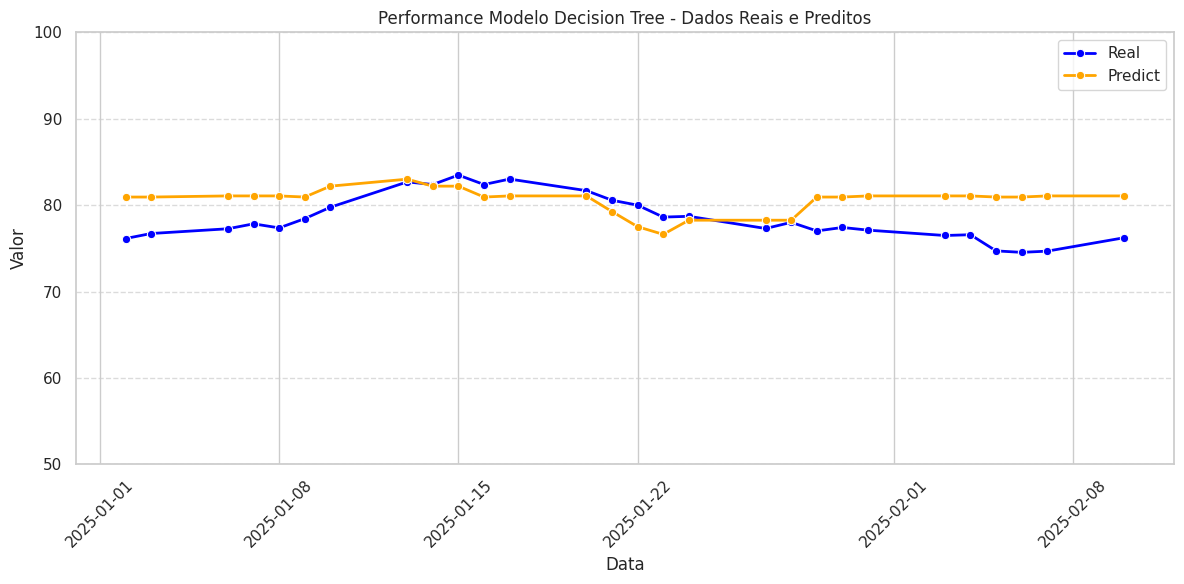

In [259]:
# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='y', data=result_dt, label='Real', marker='o', color='blue', linewidth=2)
sns.lineplot(x='ds', y='dt_predict', data=result_dt, label='Predict', marker='o', color='orange', linewidth=2)
plt.ylim(50,100)
# Adicionar intervalo de confiança se disponível (substitua 'ic_lower' e 'ic_upper' com seus nomes reais)
# sns.fill_between(x=result_a['ds'], y1=result_a['ic_lower'], y2=result_a['ic_upper'], color='gray', alpha=0.2, label='Confidence Interval')

# Adicionar rótulos e legendas
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Performance Modelo Decision Tree - Dados Reais e Preditos')
plt.legend()

# Rotacionar as datas para melhorar a legibilidade
plt.xticks(rotation=45)

# Adicionar grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

**7.4 Regressor de floresta aleatória**

In [260]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( X_train_lr, y_train_lr )

# prediction
yhat_rf = rf.predict( X_test_lr )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test_lr ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,2.881918e+35,1342.627611,5.839466e+35


**7.5 Comparando performance dos modelos**

**7.5.1 Desempenho simples**

In [261]:
modelling_result = pd.concat( [lr_result, arima_result, dt_result, ] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Arima Model,4.189185,0.052376,4.918991
0,Decision Tree,5.062063,0.067906,5.878641
0,Linear Regression,14.061057,0.188926,17.084343


**8.0 Desempenho de aprendizado de máquina**

In [262]:
df8 = result_lr.merge(result_a, on='index',how='left')
df9 = df8.merge(result_dt, on='index',how='left')

In [263]:
df9 = df9.drop(columns={'ds_y','y_y','ds','y'})
df9.rename(columns={'ds_x':'ds','y_x':'y_real','predicted_mean':'arima_predict'},inplace=True)

In [264]:
df9['error_arima'] = df9['y_real'] - df9['arima_predict']
df9['error_lr'] = df9['y_real'] - df9['lr_predict']
df9['error_dt'] = df9['y_real'] - df9['dt_predict']
df9.sample(10)

,index,ds,y_real,lr_predict,arima_predict,dt_predict,error_arima,error_lr,error_dt
20,20,2025-01-30,77.42,85.669133,74.364,80.94,3.056,-8.249133,-3.52
6,6,2025-01-10,79.76,84.079371,73.788,82.20,5.972,-4.319371,-2.44
9,9,2025-01-15,83.48,84.156586,74.377,82.20,9.103,-0.676586,1.28
14,14,2025-01-22,80.00,85.300323,74.321,77.51,5.679,-5.300323,2.49
1,1,2025-01-03,76.72,83.332256,74.045,80.94,2.675,-6.612256,-4.22
23,23,2025-02-04,76.58,86.413826,74.123,81.07,2.457,-9.833826,-4.49
13,13,2025-01-21,80.57,83.321169,74.372,79.26,6.198,-2.751169,1.31
4,4,2025-01-08,77.37,84.009434,74.254,81.07,3.116,-6.639434,-3.70
11,11,2025-01-17,83.02,83.425004,74.426,81.07,8.594,-0.405004,1.95
27,27,2025-02-10,76.23,87.164313,74.137,81.07,2.093,-10.934313,-4.84


<Axes: xlabel='ds', ylabel='y'>

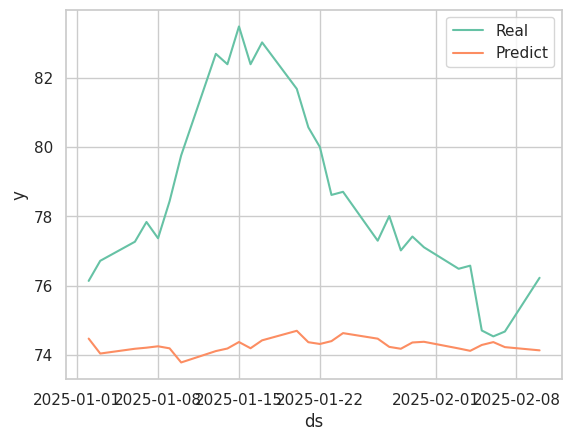

In [265]:
sns.lineplot( x='ds', y='y', data=result_a, label='Real' )
sns.lineplot( x='ds', y='predicted_mean', data=result_a, label='Predict' )

**9.0 Conclusão final**

Período Utilizado:
O período utilizado para o treinamento e teste dos modelos foi de 4 de janeiro de 2021 a 10 de fevereiro de 2025. Este período foi dividido em conjuntos de treinamento e teste para avaliar a performance dos modelos.

Métrica de Avaliação do Erro:
A métrica de avaliação do erro utilizada foi o RMSE (Root Mean Squared Error), que mede a diferença entre os valores preditos e os valores reais. O RMSE é uma métrica comum para avaliar a precisão de modelos de previsão, pois penaliza grandes erros de forma mais severa.

Modelo Vencedor: O modelo com o menor valor de RMSE é considerado o modelo vencedor, pois apresenta a melhor precisão na previsão dos preços do petróleo.

**10.0 - Aplicando RNN LSTM (Long Short-Term Memory)**

In [266]:
!pip install keras pandas tensorflow

**10.1 - Loading Data and EDA**

In [267]:
import pandas as pd

# Replace with the raw file URL from GitHub
url = 'https://raw.githubusercontent.com/TorNDark/TechChallenge_Fase4/main/preco_petroleo_ipea_base_2015_2025.xlsx'

# Fetch the file content
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses

# Read the Excel data using 'openpyxl' engine
df = pd.read_excel(io.BytesIO(response.content), engine='openpyxl')

# Use the loaded DataFrame 'df' instead of the URL string 'url'
ibovespa_merged = df.copy() # create a copy of the loaded DataFrame

# Convert 'Data' to datetime and check for missing values
ibovespa_merged['Data'] = pd.to_datetime(ibovespa_merged['Data'], format='%d.%m.%Y')


# Settar indice em Data e dar sort
ibovespa_merged.set_index('Data', inplace=True)
ibovespa_merged.sort_index(inplace=True)

ibovespa_merged.tail()

,Preco
Data,
2025-02-04,76.58
2025-02-05,74.71
2025-02-06,74.54
2025-02-07,74.68
2025-02-10,76.23


In [268]:
# Filter data between two dates
# Irei filtrar dados de 5 anos para ter ideia de como se comportará o LSTM
ibovespa_filtered = ibovespa_merged.query("Data >= '2024-01-01'")

ibovespa_filtered.head()

,Preco
Data,
2024-01-02,76.24
2024-01-03,77.18
2024-01-04,75.79
2024-01-05,78.31
2024-01-08,75.47


In [269]:
train_data, test_data = ibovespa_filtered[0:int(len(ibovespa_filtered)*0.9)], ibovespa_filtered[int(len(ibovespa_filtered)*0.9):]
train_data

,Preco
Data,
2024-01-02,76.24
2024-01-03,77.18
2024-01-04,75.79
2024-01-05,78.31
2024-01-08,75.47
...,...
2024-12-23,72.12
2024-12-24,73.50
2024-12-26,73.50


In [270]:
train = train_data.iloc[:, 0:1].values # selecting closing prices
len(train)

252

In [271]:
# Importando bibliotecas necessárias
from sklearn.preprocessing import MinMaxScaler  # Para escalonamento de dados
import numpy as np  # Biblioteca para operações de álgebra linear

# Inicializando o objeto MinMaxScaler
scaler = MinMaxScaler()
# Aplicando o escalonamento aos dados de treino.
# Isso transforma os dados para que fiquem dentro do intervalo [0, 1], o que é útil para melhorar a performance do modelo.
train_scaled = scaler.fit_transform(train)

# Definindo o número de timesteps.
# timesteps é o número de pontos de tempo anteriores usados para prever o próximo ponto.
timesteps = 7

# Inicializando listas para armazenar os dados de entrada (X_train) e saída (y_train) do modelo
X_train = []
y_train = []

# Loop para criar sequências de entrada e saídas correspondentes
for i in range(timesteps, train.shape[0]):
    # Para cada ponto no conjunto de dados, exceto os últimos 'timesteps' pontos,
    # cria uma sequência de 'timesteps' pontos anteriores como entrada
    X_train.append(train_scaled[i-timesteps:i, 0])  # Adicionando a sequência de entrada

    # O valor imediatamente seguinte a essa sequência é usado como saída
    y_train.append(train_scaled[i, 0])  # Adicionando o valor de saída correspondente

# Convertendo as listas para arrays NumPy para uso em modelos de aprendizado de máquina
X_train, y_train = np.array(X_train), np.array(y_train)

# Resumo: Este código está preparando os dados de entrada e saída para treinar um modelo de séries temporais.
# Cada entrada é uma sequência de 7 pontos de dados, e a saída correspondente é o ponto de dados
# que segue esses 7 pontos na série.
X_train, y_train

(array([[0.2599737 , 0.30118369, 0.24024551, ..., 0.22621657, 0.33581762,
         0.35729943],
        [0.30118369, 0.24024551, 0.35072337, ..., 0.33581762, 0.35729943,
         0.43402017],
        [0.24024551, 0.35072337, 0.22621657, ..., 0.35729943, 0.43402017,
         0.41999123],
        ...,
        [0.14072775, 0.20078913, 0.17492328, ..., 0.12626041, 0.07935116,
         0.13985094],
        [0.20078913, 0.17492328, 0.15081105, ..., 0.07935116, 0.13985094,
         0.13985094],
        [0.17492328, 0.15081105, 0.12626041, ..., 0.13985094, 0.13985094,
         0.15168786]]),
 array([0.43402017, 0.41999123, 0.41429198, 0.43138974, 0.37571241,
        0.47040772, 0.45594038, 0.49934239, 0.51424814, 0.51907058,
        0.52696186, 0.57124068, 0.59973696, 0.60631302, 0.55545813,
        0.5212626 , 0.40464708, 0.39412538, 0.44498027, 0.47654537,
        0.55677335, 0.58176238, 0.59491451, 0.63174046, 0.61814993,
        0.6146427 , 0.63875493, 0.6668128 , 0.63437089, 0.63393249,
 

In [272]:
import numpy as np
from numpy.random import seed

# Reshaping X_train for Neural Network Input
# X_train é um array NumPy contendo os dados de entrada para o modelo de rede neural.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Esta linha remodela X_train para a forma (número de amostras, timesteps, número de características por timestep).
# Em redes neurais recorrentes como LSTM, espera-se que a entrada seja um tensor 3D com essa forma.
# Aqui, estamos configurando apenas uma característica por timestep (daí o '1' no final).

# Definindo uma semente (seed) para a geração de números pseudoaleatórios
seed(2019)
# A função seed(2019) inicializa o gerador de números aleatórios com uma semente fixa (2019).
# Isso é feito para garantir a reproducibilidade. Ou seja, cada vez que o código é executado,
# ele produzirá os mesmos resultados, o que é vital para a validação e comparação de modelos de aprendizado de máquina.
# Sem definir uma semente fixa, cada execução pode ter resultados ligeiramente diferentes devido à aleatoriedade
# em certas operações de aprendizado de máquina, como a inicialização dos pesos da rede neural.

In [273]:
# Importando as bibliotecas necessárias para a construção do modelo de rede neural
from keras.models import Sequential  # Para criar uma estrutura sequencial do modelo
from keras.layers import Dense       # Para adicionar camadas densamente conectadas (fully connected)
from keras.layers import LSTM        # Para adicionar camadas LSTM, úteis em sequências temporais
from keras.layers import Dropout     # Para adicionar camadas de regularização Dropout

# Importando a função para escalonamento de dados
from sklearn.preprocessing import MinMaxScaler

# Preparação dos dados: Escalonamento dos dados de treinamento para o intervalo [0, 1]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)  # Escalonando os dados de treinamento

# Definição dos timesteps, que são os passos temporais utilizados nas sequências de entrada
X_train = []  # Lista para armazenar os dados de entrada
y_train = []  # Lista para armazenar os rótulos (valores de saída esperados)

# Estruturação dos dados de treinamento para se adequarem ao modelo de rede neural recorrente
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])  # Adicionando a sequência de timesteps anteriores
    y_train.append(train_scaled[i, 0])              # Adicionando o valor atual como rótulo

# Convertendo as listas em arrays NumPy para uso no modelo de aprendizado de máquina
X_train, y_train = np.array(X_train), np.array(y_train)

# Construção do modelo sequencial usando Keras
model = Sequential()

# Adicionando camadas à rede neural para previsão de séries temporais

# Adicionando a primeira camada LSTM (Long Short-Term Memory)
model.add(LSTM(
    units = 50,  # Número de unidades (neurônios) na camada, um indicador da "capacidade" da camada
    return_sequences = True,  # Mantém as sequências completas como saída para a próxima camada LSTM
    input_shape = (X_train.shape[1], 1)  # Define a forma da entrada (número de timesteps e recursos por timestep)
))

# A camada LSTM é crucial para modelar dependências em sequências temporais, como preços de ações.
# Ela é capaz de aprender a partir de longas sequências de dados, mantendo informações importantes e esquecendo as irrelevantes.

# Adicionando a camada de Dropout para regularização
model.add(Dropout(0.25))  # Descarta 25% das unidades aleatoriamente para prevenir overfitting

# O Dropout é uma técnica de regularização eficaz para reduzir o overfitting em redes neurais,
# especialmente útil em redes profundas e complexas.

# Adicionando mais camadas LSTM e Dropout
# Essas camadas adicionais aumentam a capacidade do modelo de aprender padrões complexos nos dados.

model.add(LSTM(units = 50, return_sequences = True))  # Outra camada LSTM
model.add(Dropout(0.25))  # Dropout aumentado para 25% para maior regularização

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))  # Dropout de 20%

# A última camada LSTM não tem return_sequences = True,
# isso indica que a sequência completa não é mais necessária nas saídas
model.add(LSTM(units = 50))  # Última camada LSTM

# Adicionando outra camada de Dropout
model.add(Dropout(0.25))  # Dropout de 25%

# A estrutura de múltiplas camadas LSTM seguidas por Dropout é uma configuração comum em tarefas de previsão de séries temporais.
# Isso permite que o modelo capture padrões complexos e de longo alcance nos dados,
# enquanto o Dropout ajuda a garantir que o modelo não se ajuste excessivamente aos dados de treinamento.

# Adicionando a camada de saída
model.add(Dense(units = 1))

# Compilando a rede neural recorrente
# Usando 'adam' como otimizador e 'mean_squared_error' como função de perda
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Treinando o modelo com os dados de treinamento
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.2170
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0857
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0410
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0358
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0312
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0228
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0192
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0185
Epoch 9/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0168
Epoch 10/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0155
Epoch 11/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0150
Epoch 12/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0193
Epoch 13/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0156
Epoch 14/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0156
Epoch 15/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0200
Epoch 16/40
8/8 ━━━━━━━━━━━━━━━━━

In [274]:
# Preparação dos dados de teste
# Extraindo os preços reais das ações (valor de fechamento) do conjunto de teste
real_stock_price = test_data.iloc[:,0:1].values

# Combinando os dados de treinamento e teste para formar sequências de entrada para a previsão
# Fix: Use .index instead of ['Data'] to access the dates
# combine = pd.concat((train_data.index, test_data.index), axis = 0)
combine = pd.concat([pd.Series(train_data.index), pd.Series(test_data.index)], axis=0)

# Preparando as entradas de teste, incluindo os preços das ações dos últimos timesteps
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Fix: Ensure test_inputs is numeric before scaling
test_inputs = test_inputs.astype(np.float64)

test_inputs = scaler.transform(test_inputs)

# Processando os dados de teste da mesma forma que os dados de treinamento
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Realizando previsões com o modelo treinado
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


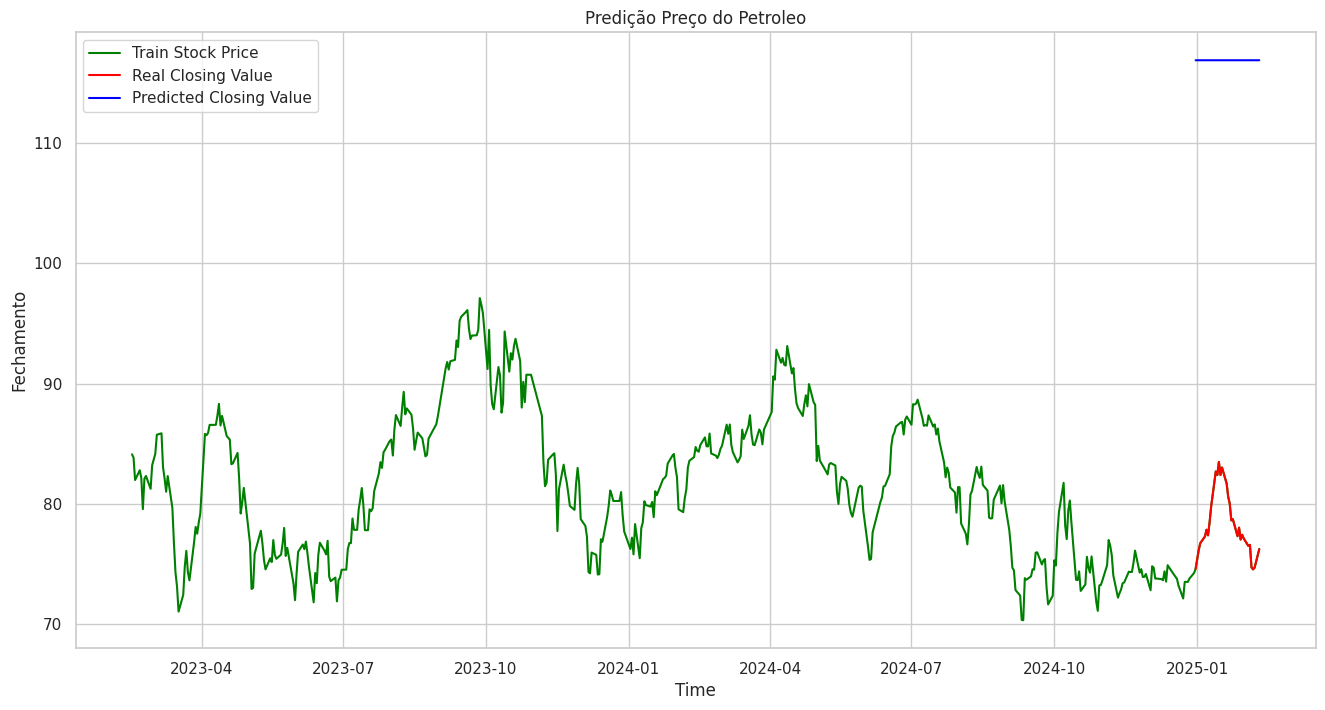

MSE: 1493.2149634983546
MAE: 38.55173157790611
RMSE: 38.64213973757606


In [275]:
from matplotlib  import pyplot as plt
close_up_df = 500

plt.figure(figsize=(16,8))
# Fix: Use ibovespa_merged['Preco'] for y-values and limit x-axis using .iloc
plt.plot(ibovespa_merged.index[-close_up_df:], ibovespa_merged['Preco'].iloc[-close_up_df:], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Closing Value')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Closing Value')
plt.title('Predição Preço do Petroleo')
plt.xlabel('Time')
plt.ylabel('Fechamento')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

In [276]:
# Inicializando as variáveis
# Inicializando as variáveis
size = len(ibovespa_merged)
# Fix: Use .index to access the dates
array_last_7_days = ibovespa_merged.index[size - 7: size].values
array_last_7_days = array_last_7_days.reshape(-1,1)

# Convert dates to numerical representation for scaling
# Fix: Convert dates to Unix timestamps before scaling
array_last_7_days = array_last_7_days.astype(np.int64) // 10**9
array_last_7_days = array_last_7_days.reshape(-1, 1)
array_last_7_days = scaler.transform(array_last_7_days)

# ... (rest of your code remains the same)

# Definindo o intervalo de datas para as previsões
start_date = '2025-01-01'
end_date = '2025-02-10'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Inicializando a lista para armazenar as previsões
predictions = []

# Loop para gerar previsões para cada data no intervalo
for current_date in date_range:
    # Fazendo a previsão para o próximo dia
    future_predict = model.predict(np.array([array_last_7_days]))
    future_predict = scaler.inverse_transform(future_predict)

    # Atualizando a lista de previsões
    predictions.append(future_predict[0, 0])

    # Transformando o valor previsto de volta para a escala original antes de atualizar a matriz
    future_predict_scaled = scaler.transform(future_predict)


    # Preparando os dados dos últimos 7 dias para a próxima iteração
    array_last_7_days = np.append(array_last_7_days[1:], future_predict_scaled).reshape(-1, 1)

# Convertendo as previsões para um DataFrame para facilitar a visualização e análise
forecast = pd.DataFrame(data={'Date': date_range, 'Predicted': predictions})

# Exibindo as previsões
print(forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/

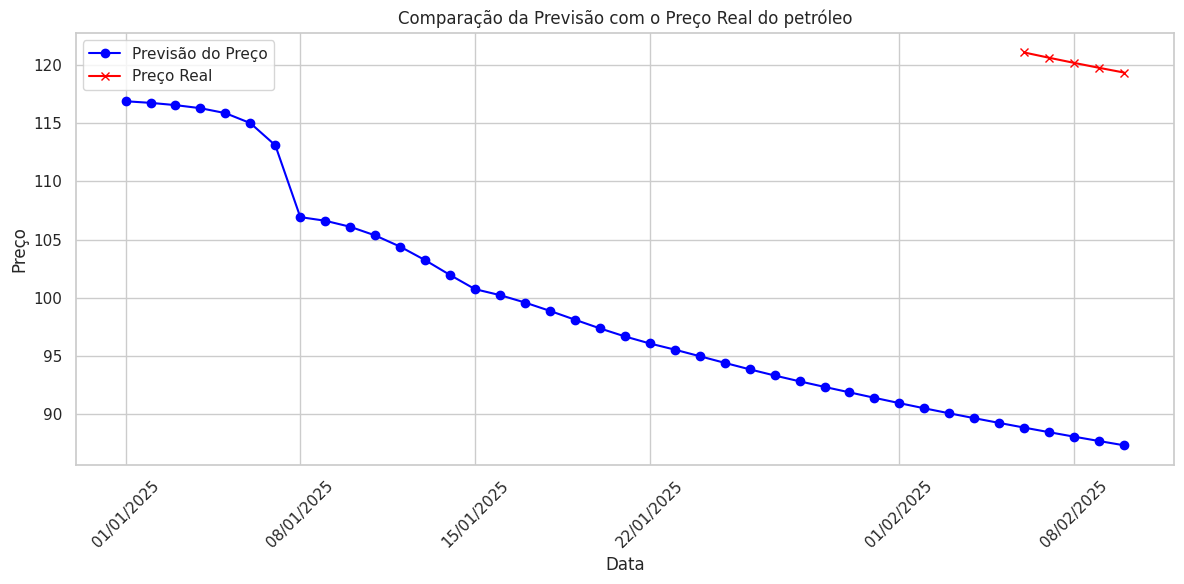

In [277]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Avaliação manual dos dados de fechamento
# Dados dos preços reais das ações
data = {
    'Date': ['2025-02-10', '2025-02-09', '2025-02-08', '2025-02-07', '2025-02-06'],
    'Price': [119.353, 119.761, 120.185, 120.624, 121.080]

}

# Convertendo para DataFrame
actual_prices = pd.DataFrame(data)
actual_prices['Date'] = pd.to_datetime(actual_prices['Date'], format='%Y-%m-%d')
actual_prices.set_index('Date', inplace=True)
actual_prices.sort_index(inplace=True)


# Criando um gráfico para visualizar as previsões e os preços reais
plt.figure(figsize=(12, 6))

# Plotando as previsões
plt.plot(forecast['Date'], forecast['Predicted'], color='blue', marker='o', linestyle='-', label='Previsão do Preço')

# Plotando os preços reais
plt.plot(actual_prices.index, actual_prices['Price'], color='red', marker='x', linestyle='-', label='Preço Real')

# Formatando a legenda do eixo x para datas
# Você pode ajustar o formato da data aqui. '%Y-%m-%d' representa o formato 'Ano-Mês-Dia'.
date_format = mdates.DateFormatter('%d/%m/%Y')
plt.gca().xaxis.set_major_formatter(date_format)

# Adicionando título, rótulos e legenda
plt.title('Comparação da Previsão com o Preço Real do petróleo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()

# Ajustando formatação da data
plt.xticks(rotation=45)
# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()